# Etap 2: Feature Engineering-Focused Data Visualization

Professional visualizations designed to inform feature engineering decisions:
- Host-related features for encoding and imputation strategies
- Core listing attributes for numerical treatment and binning
- Review scores for selection and correlation analysis
- Calendar-derived insights for time-based features
- Feature interactions and overall relationships
- Text-derived features validation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
import os
from pathlib import Path

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

# Create plots directory
plots_dir = Path("../reports/figures/etap2_professional")
plots_dir.mkdir(parents=True, exist_ok=True)

# Plot counter for sequential naming
plot_counter = 1


def save_current_plot(name_suffix, dpi=300):
    global plot_counter
    filename = f"{plot_counter:02d}_{name_suffix}.png"
    filepath = plots_dir / filename
    plt.savefig(filepath, dpi=dpi, bbox_inches="tight", facecolor="white")
    print(f"Plot saved: {filename}")
    plot_counter += 1


print("Feature engineering visualization setup complete")
print(f"Plots will be saved to: {plots_dir}")

Feature engineering visualization setup complete
Plots will be saved to: ../reports/figures/etap2_professional


## Data Loading and Preprocessing

In [6]:
processed_data_dir = "../data/processed/etap2/"

print("Loading datasets...")
listings_df = pd.read_pickle(processed_data_dir + "listings_e2_df.pkl")
calendar_df = pd.read_pickle(processed_data_dir + "calendar_e2_df.pkl")
reviews_df = pd.read_pickle(processed_data_dir + "reviews_e2_df.pkl")

print(f"Listings: {listings_df.shape}")
print(f"Calendar: {calendar_df.shape}")
print(f"Reviews: {reviews_df.shape}")

Loading datasets...
Listings: (47572, 75)
Calendar: (17363102, 5)
Reviews: (953651, 7)
Listings: (47572, 75)
Calendar: (17363102, 5)
Reviews: (953651, 7)


In [7]:
def clean_price_column(df, price_col="price"):
    df_clean = df.copy()
    df_clean["price_numeric"] = df_clean[price_col].replace({r"\$|,": ""}, regex=True)
    df_clean["price_numeric"] = pd.to_numeric(
        df_clean["price_numeric"], errors="coerce"
    )
    return df_clean


def parse_bathrooms_text(df):
    df_parsed = df.copy()
    if "bathrooms_text" in df.columns:
        df_parsed["bathrooms_numeric_count"] = (
            df_parsed["bathrooms_text"].str.extract("(\d+\.?\d*)").astype(float)
        )
        df_parsed["bathroom_type"] = df_parsed["bathrooms_text"].apply(
            lambda x: (
                "shared"
                if "shared" in str(x).lower()
                else "private" if pd.notna(x) else np.nan
            )
        )
    return df_parsed


def extract_amenities_features(df):
    df_amenities = df.copy()
    if "amenities" in df.columns:
        df_amenities["amenities_count"] = df_amenities["amenities"].str.count(",") + 1
        df_amenities["amenities_count"] = df_amenities["amenities_count"].fillna(0)

        key_amenities = ["Wifi", "Kitchen", "Air conditioning", "Pool", "Free parking"]
        for amenity in key_amenities:
            col_name = f"has_{amenity.lower().replace(' ', '_')}"
            df_amenities[col_name] = df_amenities["amenities"].str.contains(
                amenity, na=False
            )
    return df_amenities


def create_text_features(df):
    df_text = df.copy()
    if "name" in df.columns:
        df_text["name_length"] = df_text["name"].str.len()
    if "description" in df.columns:
        df_text["description_length"] = df_text["description"].str.len()
    return df_text


print("Preprocessing data...")
listings_processed = clean_price_column(listings_df)
listings_processed = parse_bathrooms_text(listings_processed)
listings_processed = extract_amenities_features(listings_processed)
listings_processed = create_text_features(listings_processed)

print("Data preprocessing complete")

Preprocessing data...
Data preprocessing complete
Data preprocessing complete


## I. Host-Related Features Analysis

Plot saved: 01_price_by_superhost_status.png


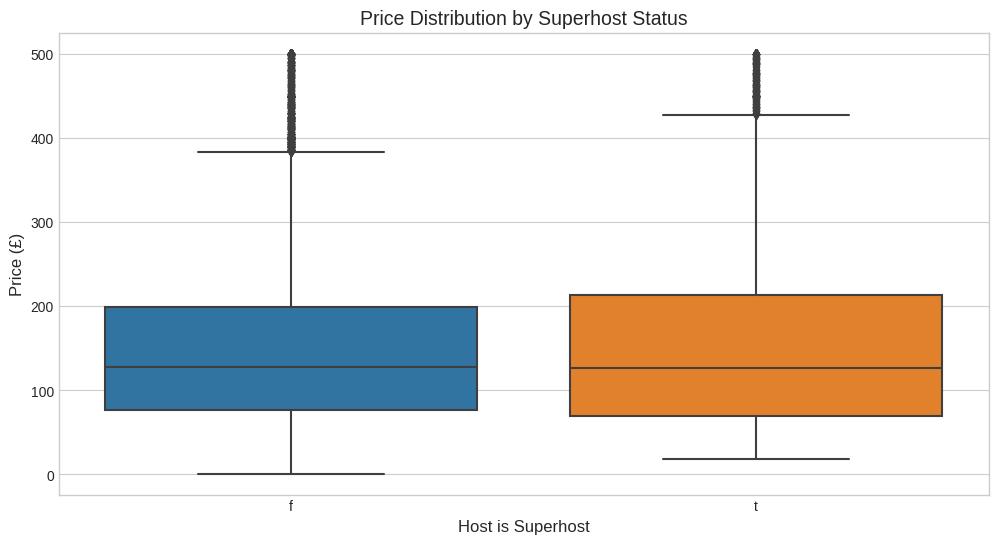

Plot saved: 02_price_by_host_identity_verified.png


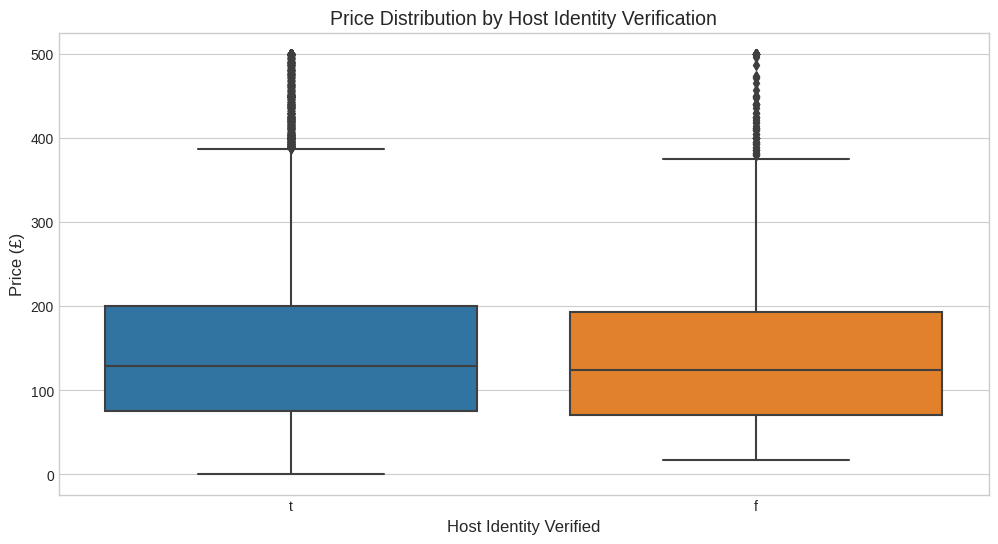

In [8]:
valid_price_data = listings_processed[
    (listings_processed["price_numeric"] > 0)
    & (
        listings_processed["price_numeric"]
        <= listings_processed["price_numeric"].quantile(0.95)
    )
]

plt.figure(figsize=(12, 6))
sns.boxplot(data=valid_price_data, x="host_is_superhost", y="price_numeric")
plt.title("Price Distribution by Superhost Status")
plt.xlabel("Host is Superhost")
plt.ylabel("Price (£)")
save_current_plot("price_by_superhost_status")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=valid_price_data, x="host_identity_verified", y="price_numeric")
plt.title("Price Distribution by Host Identity Verification")
plt.xlabel("Host Identity Verified")
plt.ylabel("Price (£)")
save_current_plot("price_by_host_identity_verified")
plt.show()

Plot saved: 03_review_scores_by_superhost_status.png


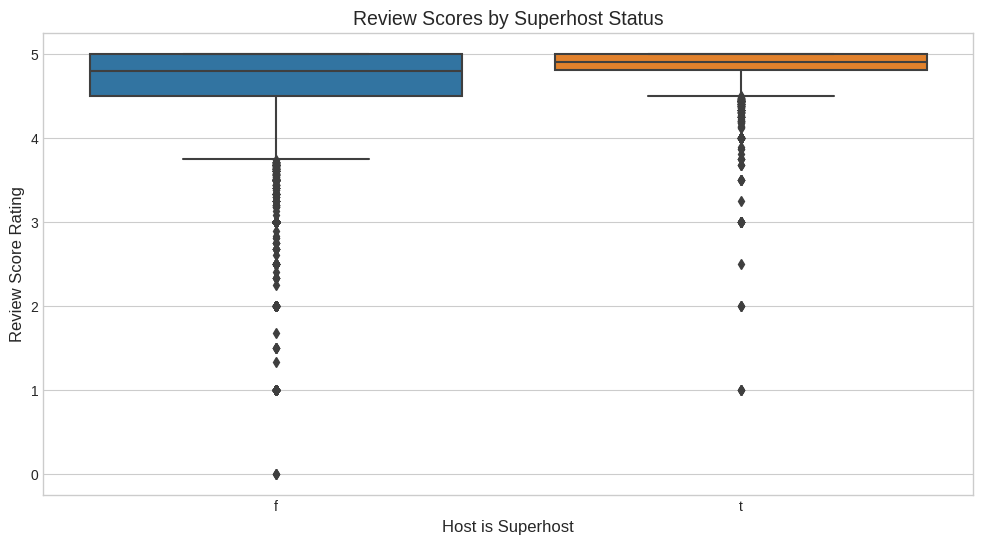

In [9]:
if "review_scores_rating" in listings_processed.columns:
    valid_review_data = listings_processed[
        listings_processed["review_scores_rating"].notna()
    ]

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=valid_review_data, x="host_is_superhost", y="review_scores_rating")
    plt.title("Review Scores by Superhost Status")
    plt.xlabel("Host is Superhost")
    plt.ylabel("Review Score Rating")
    save_current_plot("review_scores_by_superhost_status")
    plt.show()

Plot saved: 04_price_by_host_response_time.png


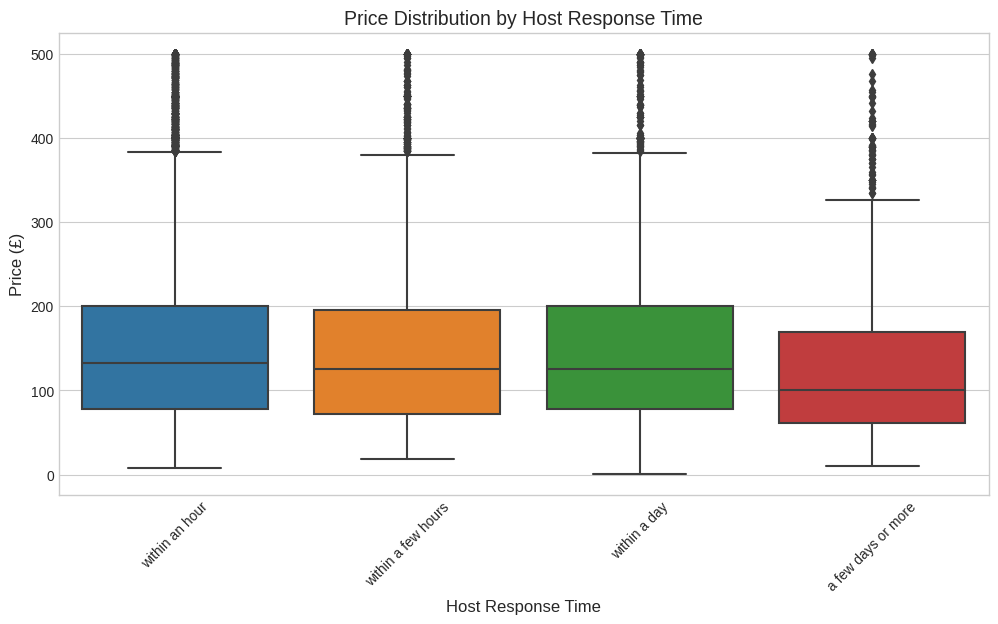

In [10]:
if "host_response_time" in listings_processed.columns:
    response_time_order = [
        "within an hour",
        "within a few hours",
        "within a day",
        "a few days or more",
    ]
    valid_response_data = listings_processed[
        listings_processed["host_response_time"].isin(response_time_order)
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
    ]

    if not valid_response_data.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=valid_response_data,
            x="host_response_time",
            y="price_numeric",
            order=response_time_order,
        )
        plt.title("Price Distribution by Host Response Time")
        plt.xlabel("Host Response Time")
        plt.ylabel("Price (£)")
        plt.xticks(rotation=45)
        save_current_plot("price_by_host_response_time")
        plt.show()

Plot saved: 05_price_vs_host_response_rate.png


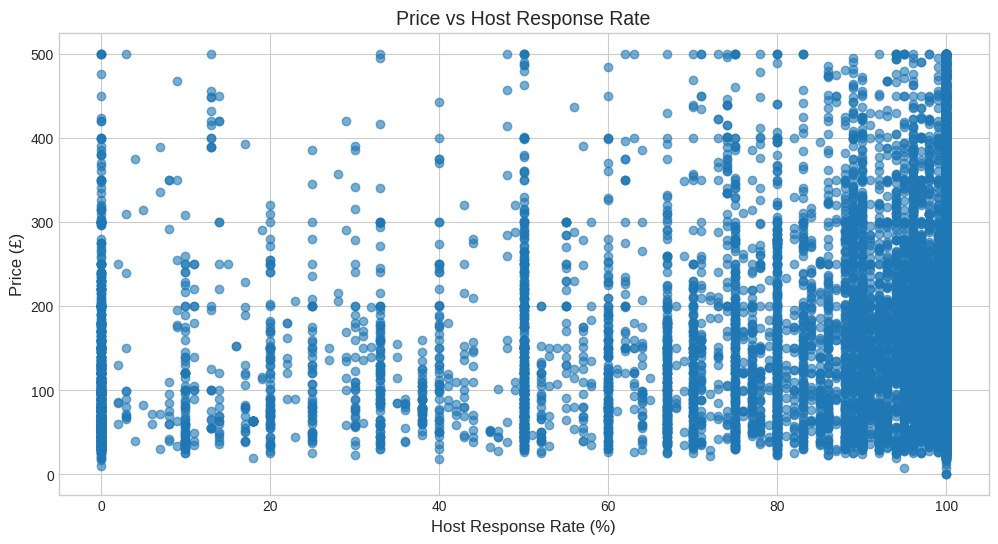

Plot saved: 06_review_scores_vs_host_response_rate.png


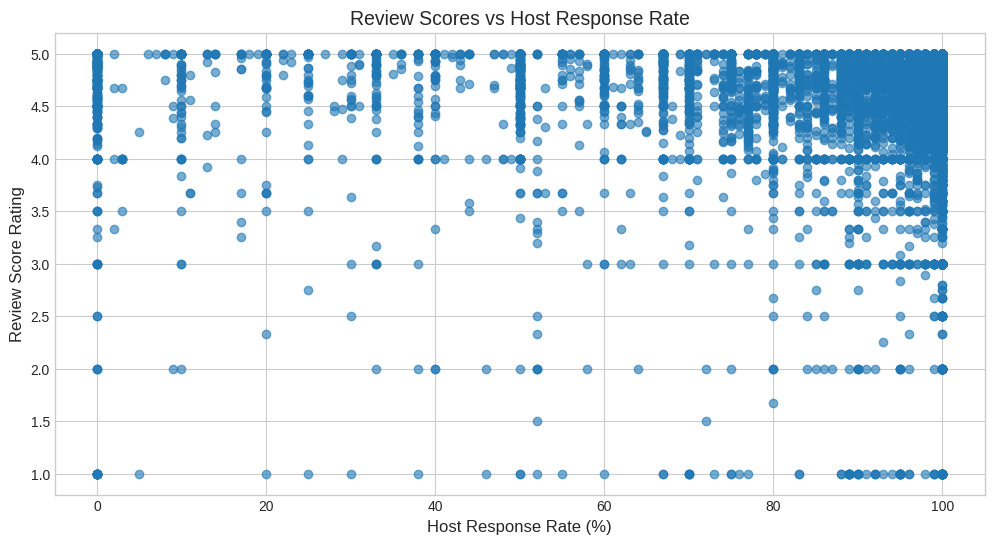

In [11]:
if "host_response_rate" in listings_processed.columns:
    listings_processed["host_response_rate_numeric"] = pd.to_numeric(
        listings_processed["host_response_rate"].str.replace("%", ""), errors="coerce"
    )

    valid_response_rate_data = listings_processed[
        listings_processed["host_response_rate_numeric"].notna()
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
    ]

    if not valid_response_rate_data.empty:
        plt.figure(figsize=(12, 6))
        plt.scatter(
            valid_response_rate_data["host_response_rate_numeric"],
            valid_response_rate_data["price_numeric"],
            alpha=0.6,
        )
        plt.title("Price vs Host Response Rate")
        plt.xlabel("Host Response Rate (%)")
        plt.ylabel("Price (£)")
        save_current_plot("price_vs_host_response_rate")
        plt.show()

        if "review_scores_rating" in valid_response_rate_data.columns:
            valid_both = valid_response_rate_data[
                valid_response_rate_data["review_scores_rating"].notna()
            ]
            if not valid_both.empty:
                plt.figure(figsize=(12, 6))
                plt.scatter(
                    valid_both["host_response_rate_numeric"],
                    valid_both["review_scores_rating"],
                    alpha=0.6,
                )
                plt.title("Review Scores vs Host Response Rate")
                plt.xlabel("Host Response Rate (%)")
                plt.ylabel("Review Score Rating")
                save_current_plot("review_scores_vs_host_response_rate")
                plt.show()

## II. Core Listing Attributes Analysis

Plot saved: 07_price_by_bedrooms.png


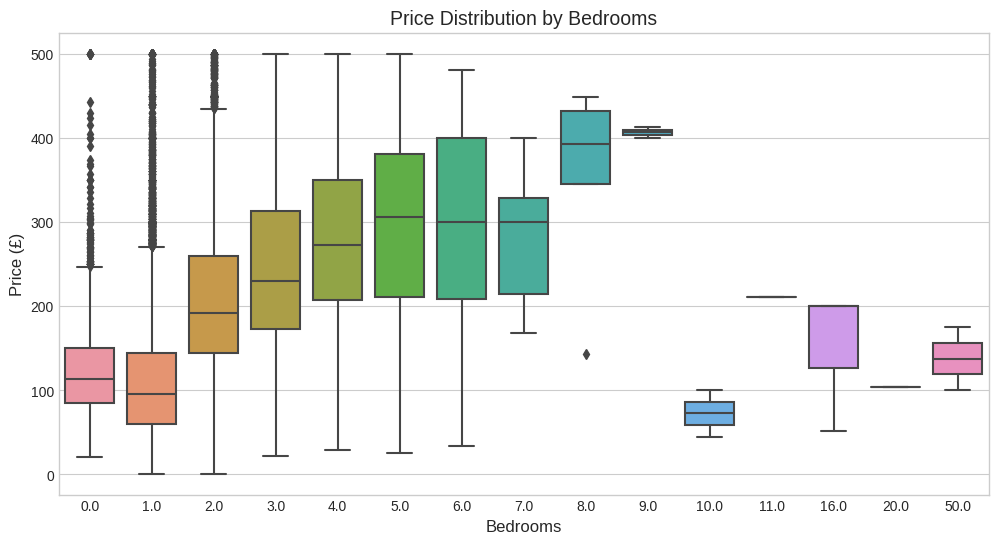

Plot saved: 08_price_by_beds.png


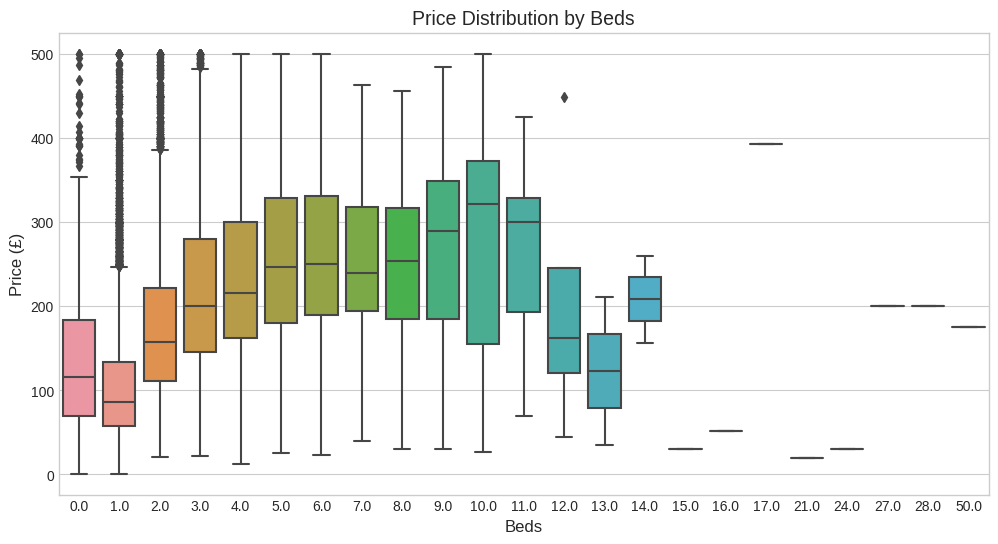

Plot saved: 09_price_by_accommodates.png


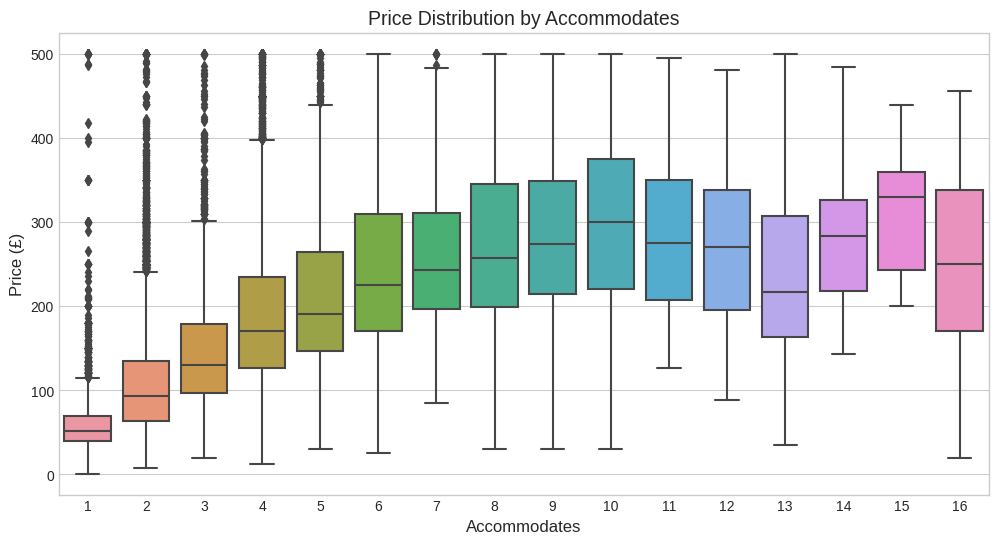

In [12]:
for attr in ["bedrooms", "beds", "accommodates"]:
    if attr in listings_processed.columns:
        valid_attr_data = listings_processed[
            (listings_processed[attr].notna())
            & (listings_processed["price_numeric"] > 0)
            & (
                listings_processed["price_numeric"]
                <= listings_processed["price_numeric"].quantile(0.95)
            )
        ]

        if not valid_attr_data.empty:
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=valid_attr_data, x=attr, y="price_numeric")
            plt.title(f"Price Distribution by {attr.title()}")
            plt.xlabel(attr.title())
            plt.ylabel("Price (£)")
            save_current_plot(f"price_by_{attr}")
            plt.show()

Plot saved: 10_price_by_bathroom_count.png


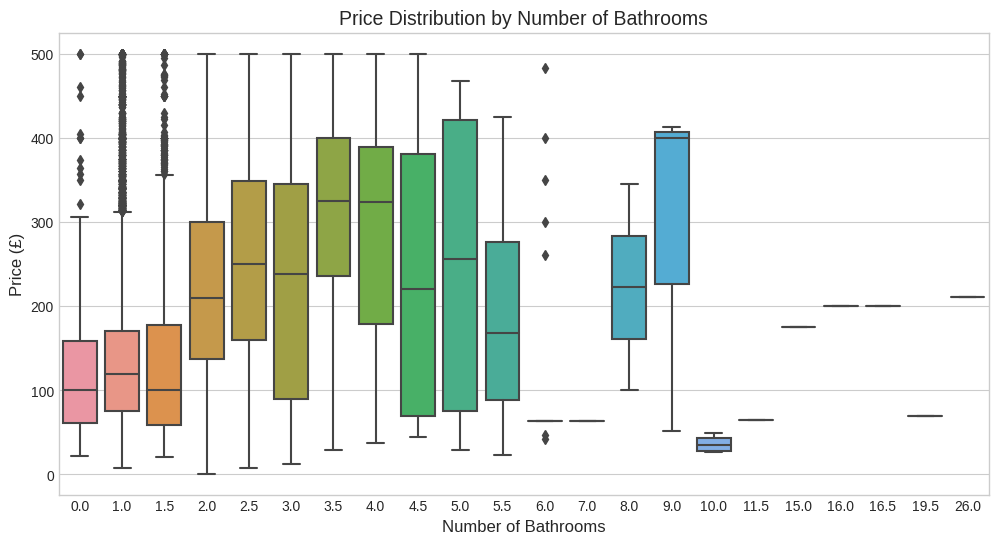

Plot saved: 11_price_by_bathroom_type.png


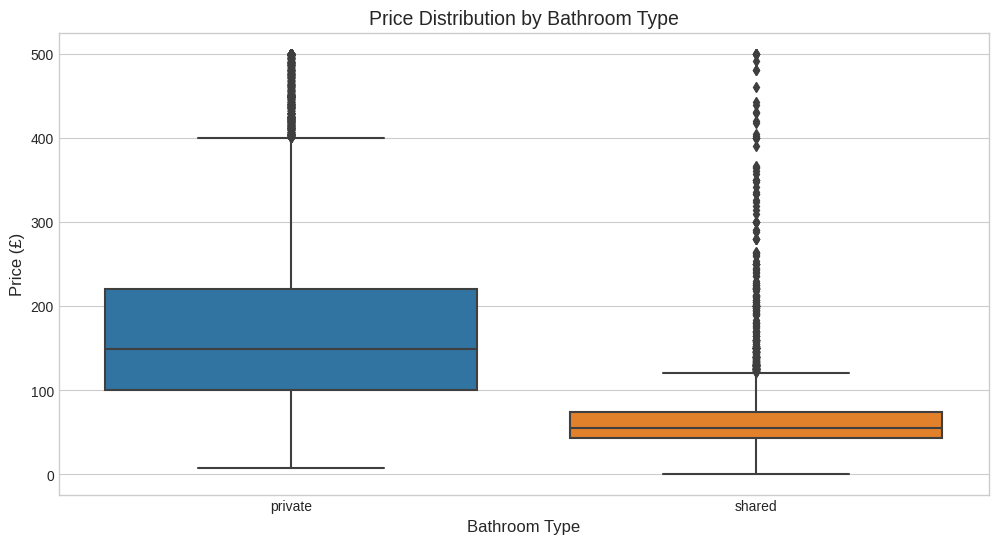

In [13]:
if "bathrooms_numeric_count" in listings_processed.columns:
    valid_bathroom_data = listings_processed[
        (listings_processed["bathrooms_numeric_count"].notna())
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
    ]

    if not valid_bathroom_data.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=valid_bathroom_data, x="bathrooms_numeric_count", y="price_numeric"
        )
        plt.title("Price Distribution by Number of Bathrooms")
        plt.xlabel("Number of Bathrooms")
        plt.ylabel("Price (£)")
        save_current_plot("price_by_bathroom_count")
        plt.show()

if "bathroom_type" in listings_processed.columns:
    valid_bath_type_data = listings_processed[
        (listings_processed["bathroom_type"].notna())
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
    ]

    if not valid_bath_type_data.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=valid_bath_type_data, x="bathroom_type", y="price_numeric")
        plt.title("Price Distribution by Bathroom Type")
        plt.xlabel("Bathroom Type")
        plt.ylabel("Price (£)")
        save_current_plot("price_by_bathroom_type")
        plt.show()

Plot saved: 12_minimum_nights_distribution.png


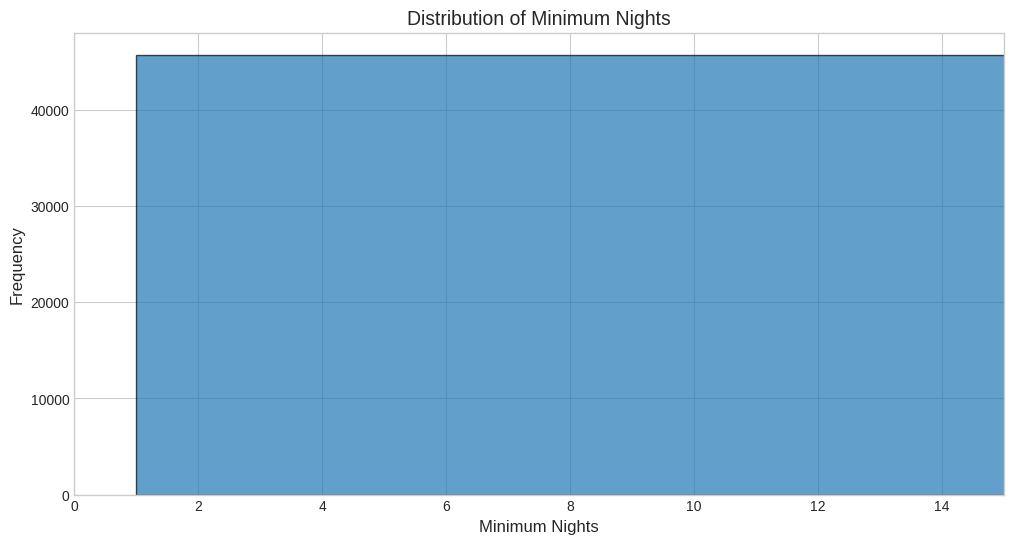

Plot saved: 13_price_vs_minimum_nights.png


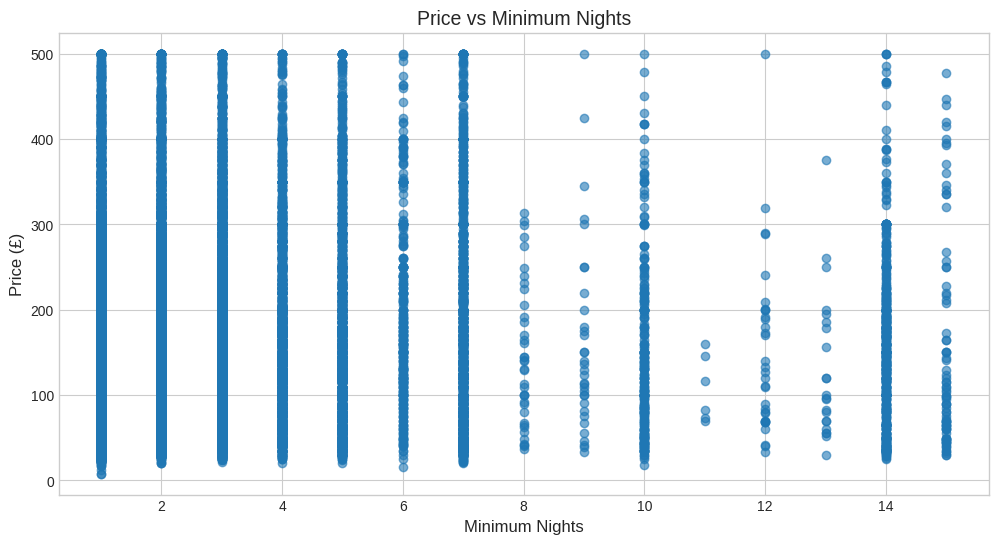

In [14]:
if "minimum_nights" in listings_processed.columns:
    min_nights_data = listings_processed[listings_processed["minimum_nights"].notna()]

    plt.figure(figsize=(12, 6))
    plt.hist(min_nights_data["minimum_nights"], bins=50, alpha=0.7, edgecolor="black")
    plt.title("Distribution of Minimum Nights")
    plt.xlabel("Minimum Nights")
    plt.ylabel("Frequency")
    plt.xlim(0, min_nights_data["minimum_nights"].quantile(0.95))
    save_current_plot("minimum_nights_distribution")
    plt.show()

    valid_min_nights_data = listings_processed[
        (listings_processed["minimum_nights"].notna())
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
        & (
            listings_processed["minimum_nights"]
            <= listings_processed["minimum_nights"].quantile(0.95)
        )
    ]

    if not valid_min_nights_data.empty:
        plt.figure(figsize=(12, 6))
        plt.scatter(
            valid_min_nights_data["minimum_nights"],
            valid_min_nights_data["price_numeric"],
            alpha=0.6,
        )
        plt.title("Price vs Minimum Nights")
        plt.xlabel("Minimum Nights")
        plt.ylabel("Price (£)")
        save_current_plot("price_vs_minimum_nights")
        plt.show()

Plot saved: 14_price_vs_amenities_count.png


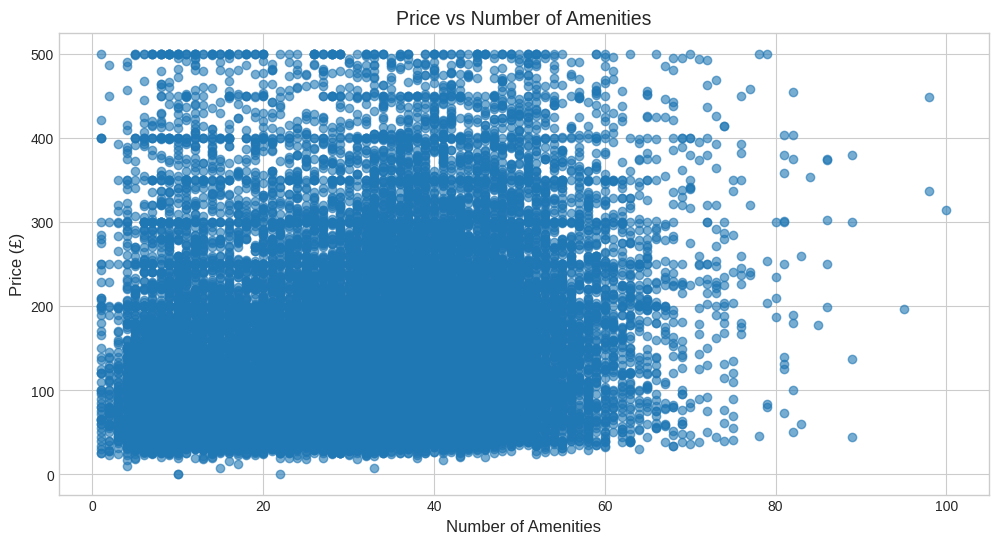

Plot saved: 15_price_by_wifi.png


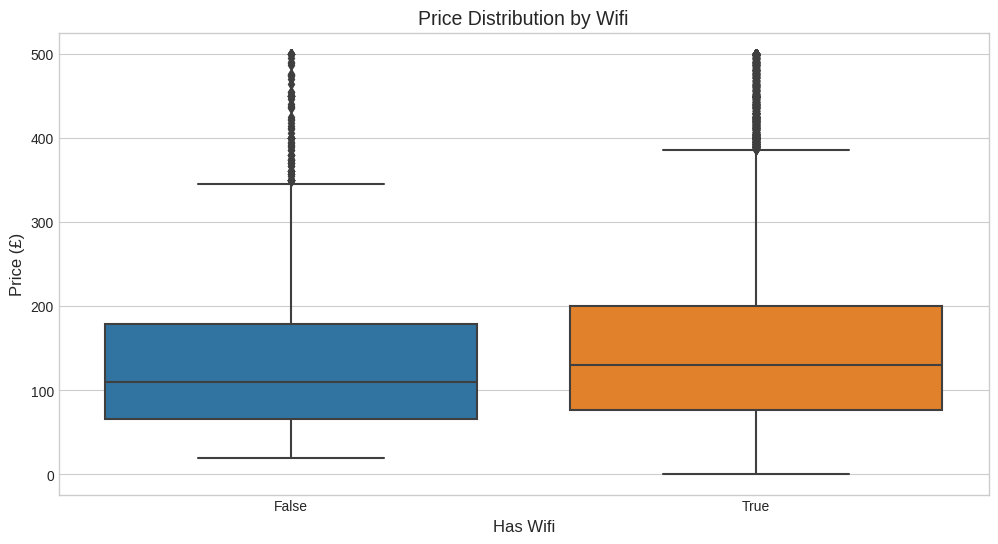

Plot saved: 16_price_by_kitchen.png


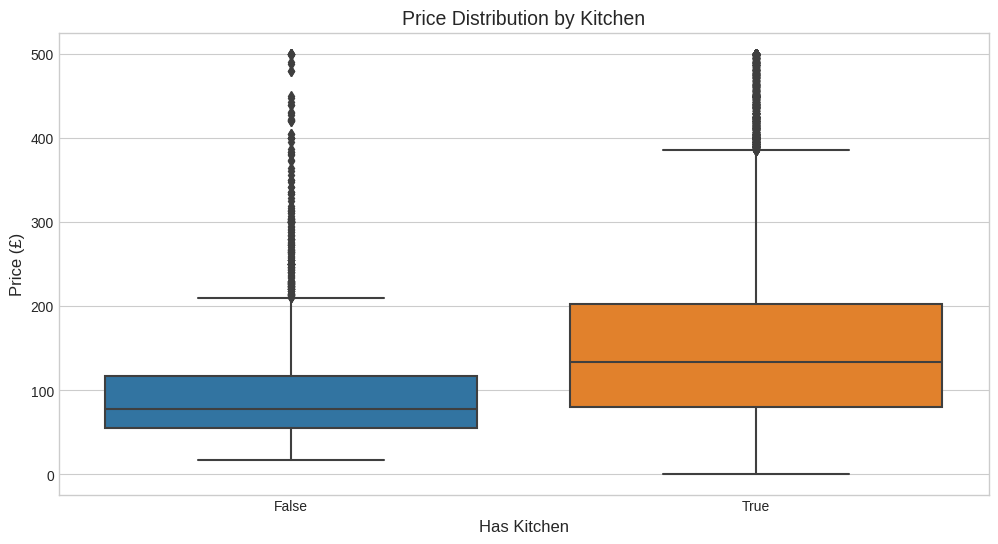

Plot saved: 17_price_by_air_conditioning.png


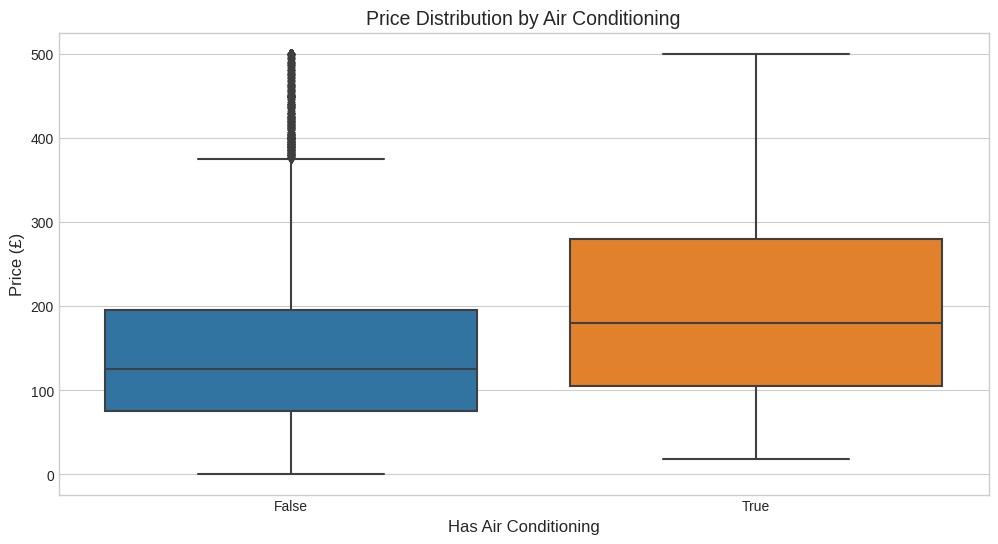

Plot saved: 18_price_by_pool.png


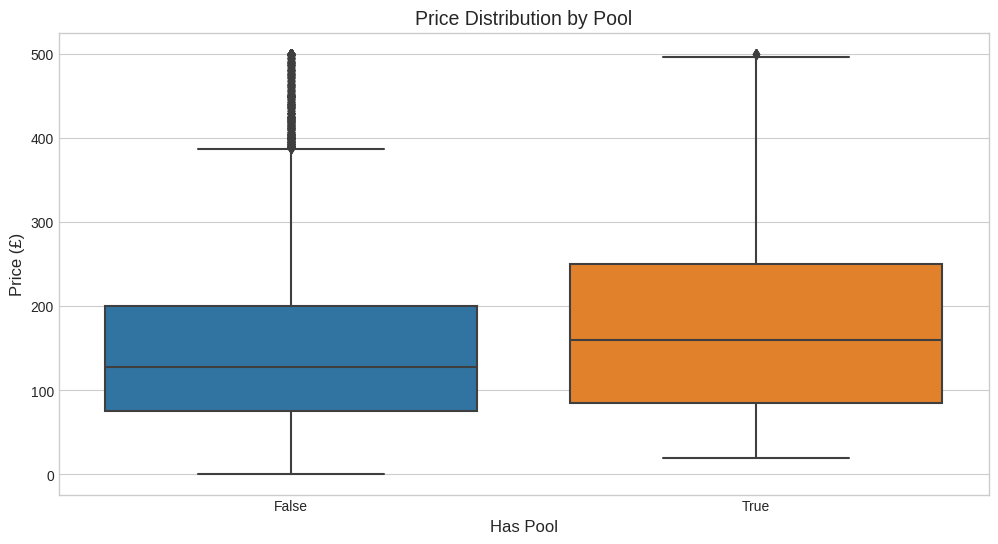

Plot saved: 19_price_by_free_parking.png


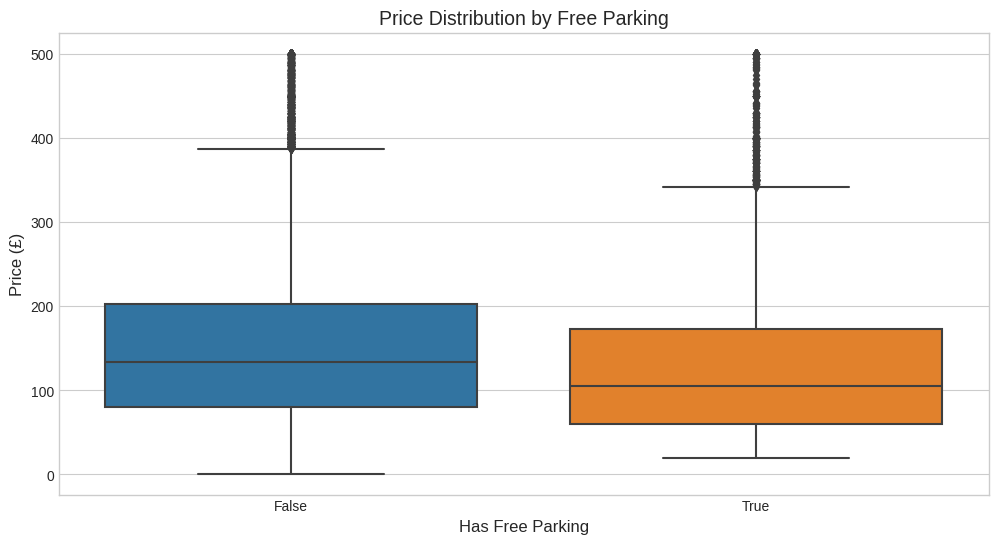

In [15]:
if "amenities_count" in listings_processed.columns:
    valid_amenities_data = listings_processed[
        (listings_processed["amenities_count"].notna())
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
    ]

    if not valid_amenities_data.empty:
        plt.figure(figsize=(12, 6))
        plt.scatter(
            valid_amenities_data["amenities_count"],
            valid_amenities_data["price_numeric"],
            alpha=0.6,
        )
        plt.title("Price vs Number of Amenities")
        plt.xlabel("Number of Amenities")
        plt.ylabel("Price (£)")
        save_current_plot("price_vs_amenities_count")
        plt.show()

key_amenities = [
    "has_wifi",
    "has_kitchen",
    "has_air_conditioning",
    "has_pool",
    "has_free_parking",
]
available_amenities = [
    col for col in key_amenities if col in listings_processed.columns
]

for amenity in available_amenities:
    valid_amenity_data = listings_processed[
        (listings_processed[amenity].notna())
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
    ]

    if not valid_amenity_data.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=valid_amenity_data, x=amenity, y="price_numeric")
        plt.title(
            f"Price Distribution by {amenity.replace('has_', '').replace('_', ' ').title()}"
        )
        plt.xlabel(f"Has {amenity.replace('has_', '').replace('_', ' ').title()}")
        plt.ylabel("Price (£)")
        amenity_name = amenity.replace("has_", "")
        save_current_plot(f"price_by_{amenity_name}")
        plt.show()

## III. Review Scores Analysis

Plot saved: 20_review_scores_correlation_matrix.png


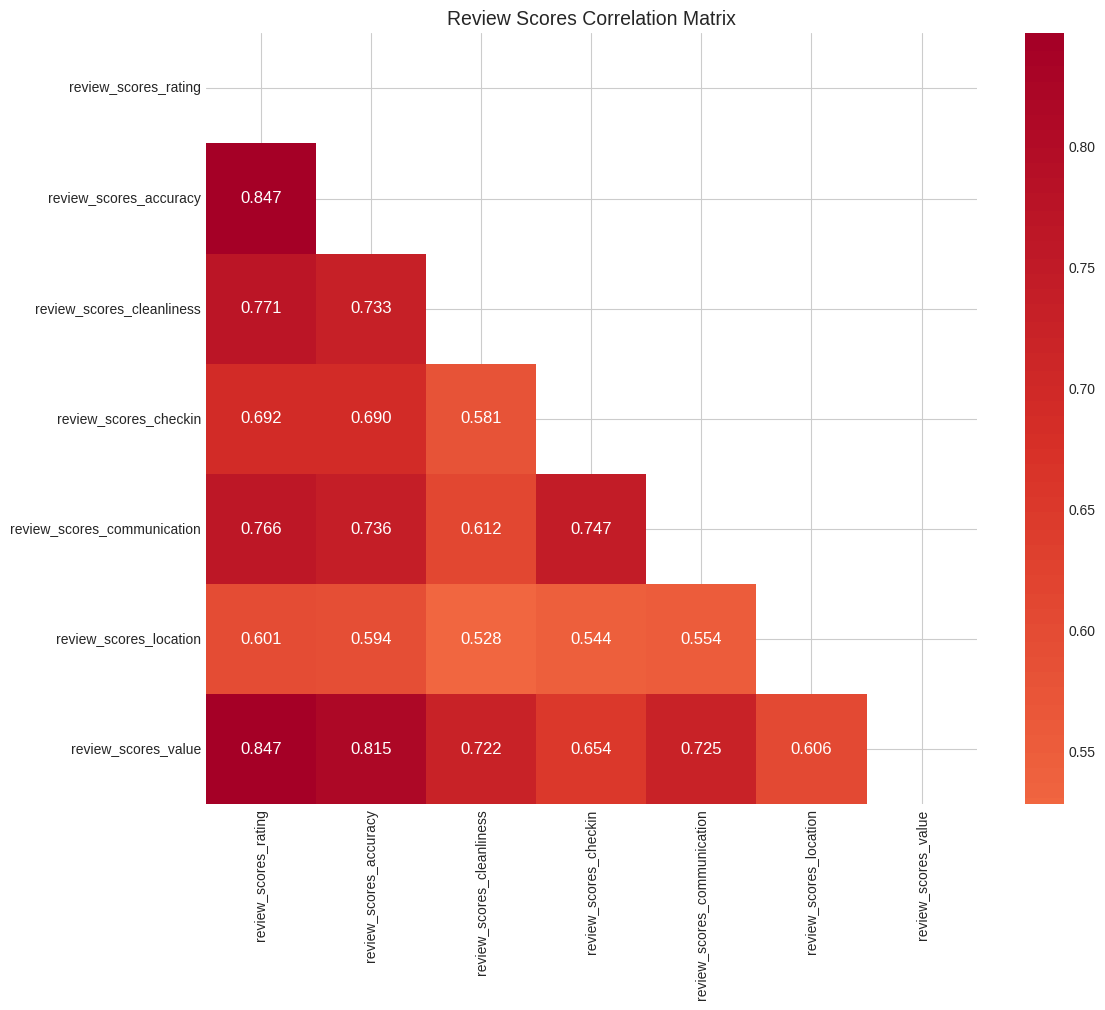

In [16]:
review_cols = [
    col for col in listings_processed.columns if col.startswith("review_scores_")
]
if review_cols:
    review_data = listings_processed[review_cols].select_dtypes(include=[np.number])

    if not review_data.empty:
        plt.figure(figsize=(12, 10))
        correlation_matrix = review_data.corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(
            correlation_matrix,
            mask=mask,
            annot=True,
            fmt=".3f",
            cmap="RdYlBu_r",
            center=0,
            square=True,
        )
        plt.title("Review Scores Correlation Matrix")
        plt.tight_layout()
        save_current_plot("review_scores_correlation_matrix")
        plt.show()

Plot saved: 21_price_vs_location.png


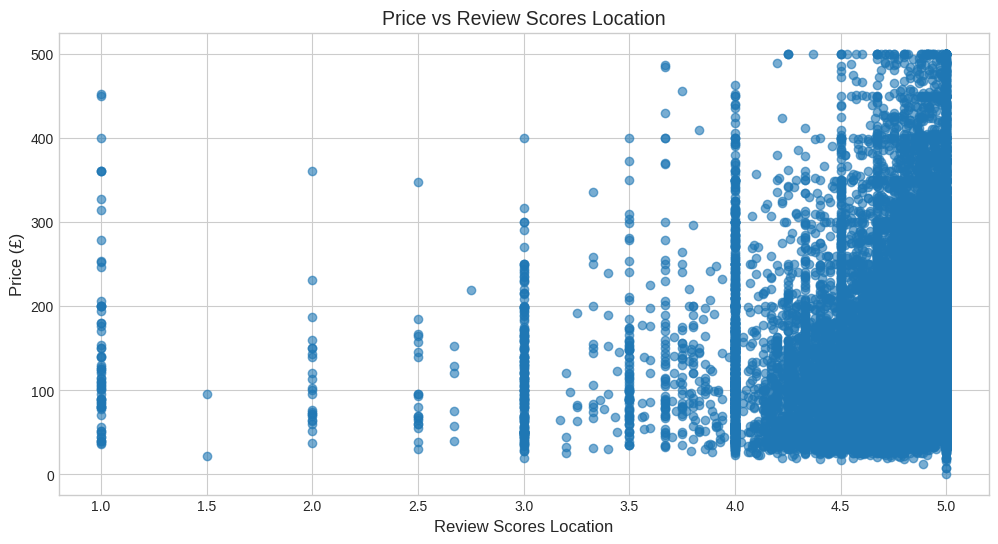

Plot saved: 22_price_vs_value.png


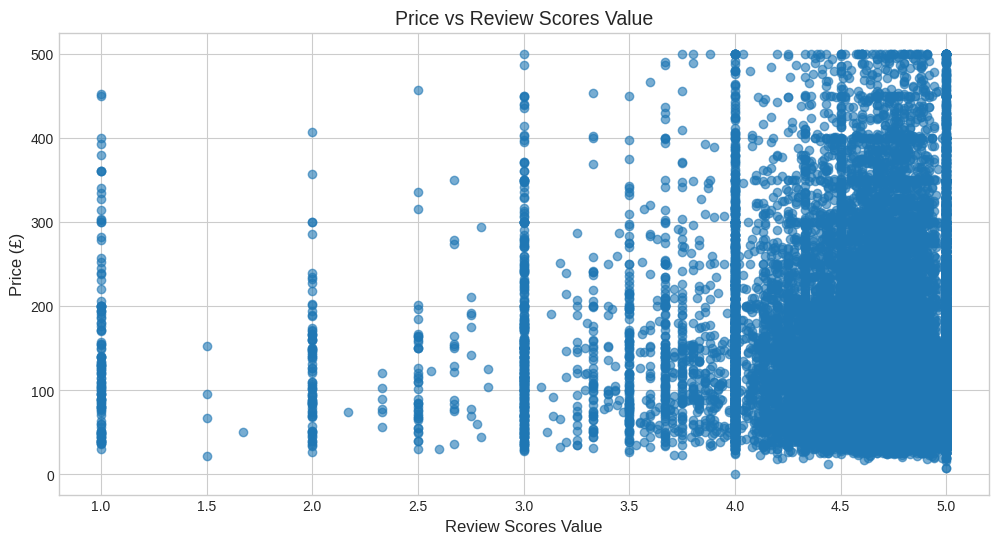

Plot saved: 23_price_vs_cleanliness.png


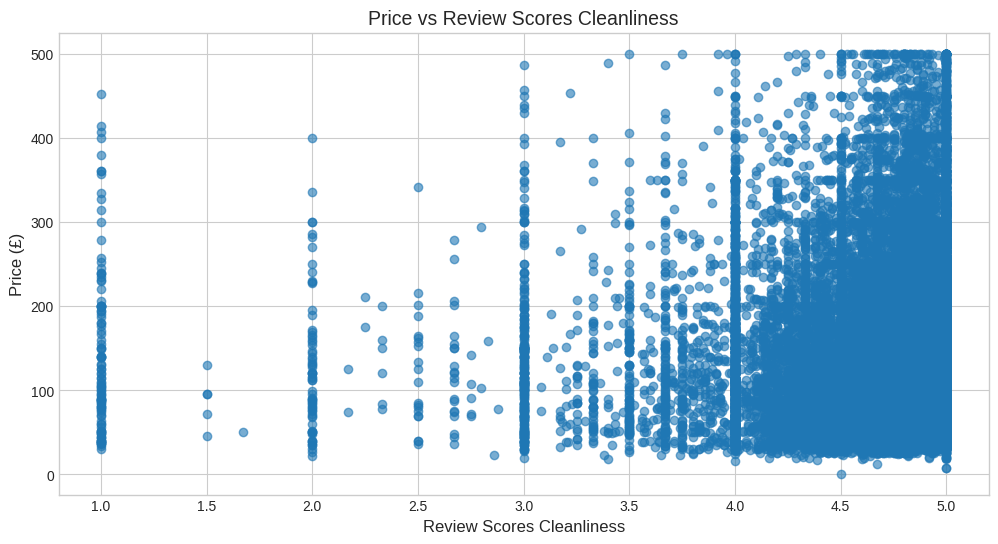

In [17]:
key_review_scores = [
    "review_scores_location",
    "review_scores_value",
    "review_scores_cleanliness",
]
available_review_scores = [
    col for col in key_review_scores if col in listings_processed.columns
]

for score in available_review_scores:
    valid_score_data = listings_processed[
        (listings_processed[score].notna())
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
    ]

    if not valid_score_data.empty:
        plt.figure(figsize=(12, 6))
        plt.scatter(
            valid_score_data[score], valid_score_data["price_numeric"], alpha=0.6
        )
        plt.title(f"Price vs {score.replace('_', ' ').title()}")
        plt.xlabel(score.replace("_", " ").title())
        plt.ylabel("Price (£)")
        score_name = score.replace("review_scores_", "")
        save_current_plot(f"price_vs_{score_name}")
        plt.show()

## IV. Calendar-Derived Insights

Plot saved: 24_average_price_by_month.png


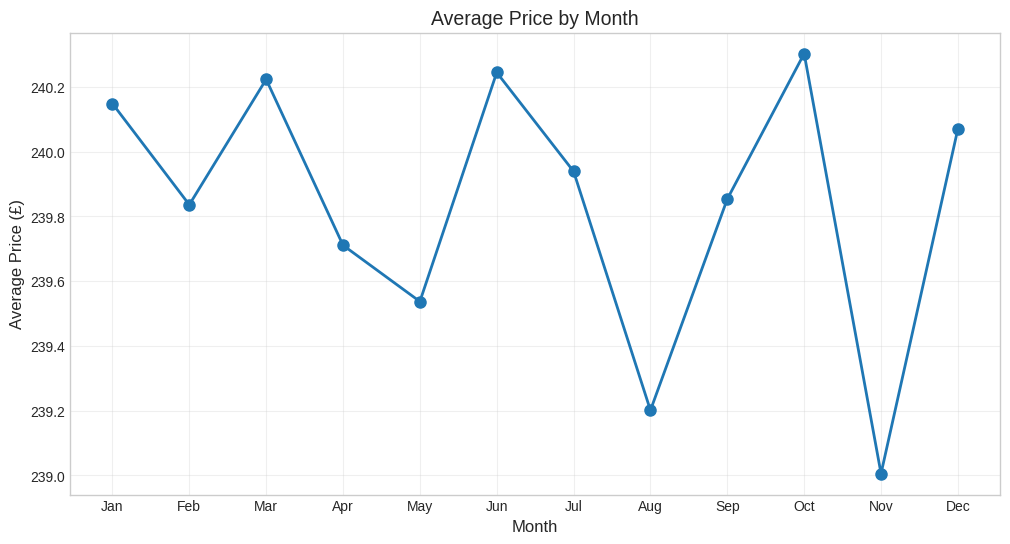

Plot saved: 25_average_price_by_day_of_week.png


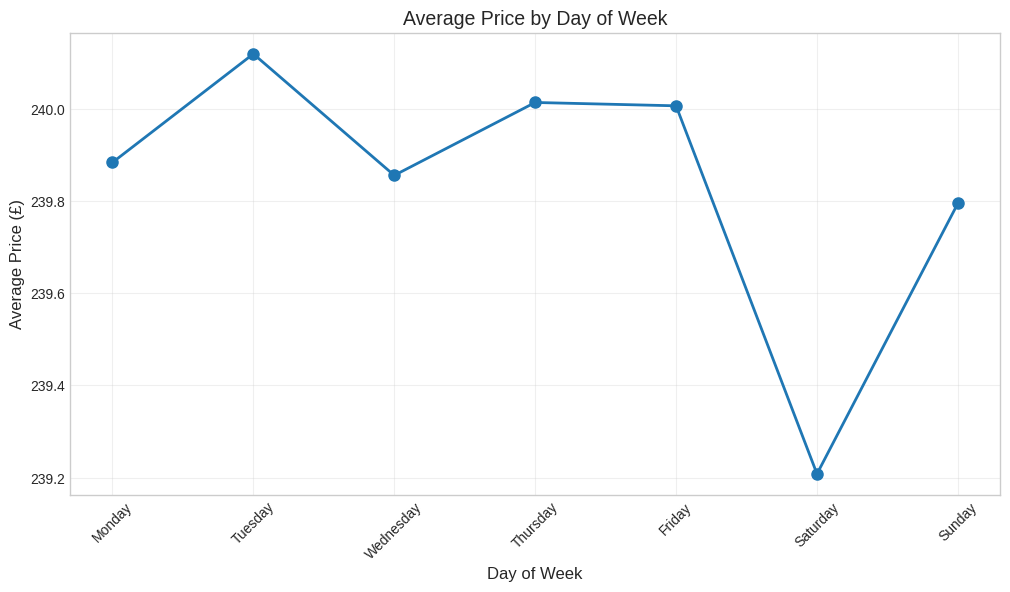

In [18]:
if "date" in calendar_df.columns and "price_cleaned" in calendar_df.columns:
    calendar_valid = calendar_df[calendar_df["price_cleaned"].notna()].copy()
    calendar_valid["date"] = pd.to_datetime(calendar_valid["date"])
    calendar_valid["month"] = calendar_valid["date"].dt.month
    calendar_valid["day_of_week"] = calendar_valid["date"].dt.dayofweek
    calendar_valid["day_name"] = calendar_valid["date"].dt.day_name()

    monthly_prices = calendar_valid.groupby("month")["price_cleaned"].mean()

    plt.figure(figsize=(12, 6))
    plt.plot(
        monthly_prices.index,
        monthly_prices.values,
        marker="o",
        linewidth=2,
        markersize=8,
    )
    plt.title("Average Price by Month")
    plt.xlabel("Month")
    plt.ylabel("Average Price (£)")
    plt.xticks(
        range(1, 13),
        [
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ],
    )
    plt.grid(alpha=0.3)
    save_current_plot("average_price_by_month")
    plt.show()

    daily_prices = calendar_valid.groupby("day_name")["price_cleaned"].mean()
    day_order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    daily_prices = daily_prices.reindex(day_order)

    plt.figure(figsize=(12, 6))
    plt.plot(
        range(len(daily_prices)),
        daily_prices.values,
        marker="o",
        linewidth=2,
        markersize=8,
    )
    plt.title("Average Price by Day of Week")
    plt.xlabel("Day of Week")
    plt.ylabel("Average Price (£)")
    plt.xticks(range(len(day_order)), day_order, rotation=45)
    plt.grid(alpha=0.3)
    save_current_plot("average_price_by_day_of_week")
    plt.show()

## V. Feature Interactions and Overall Relationships

Plot saved: 26_numerical_features_correlation_matrix.png


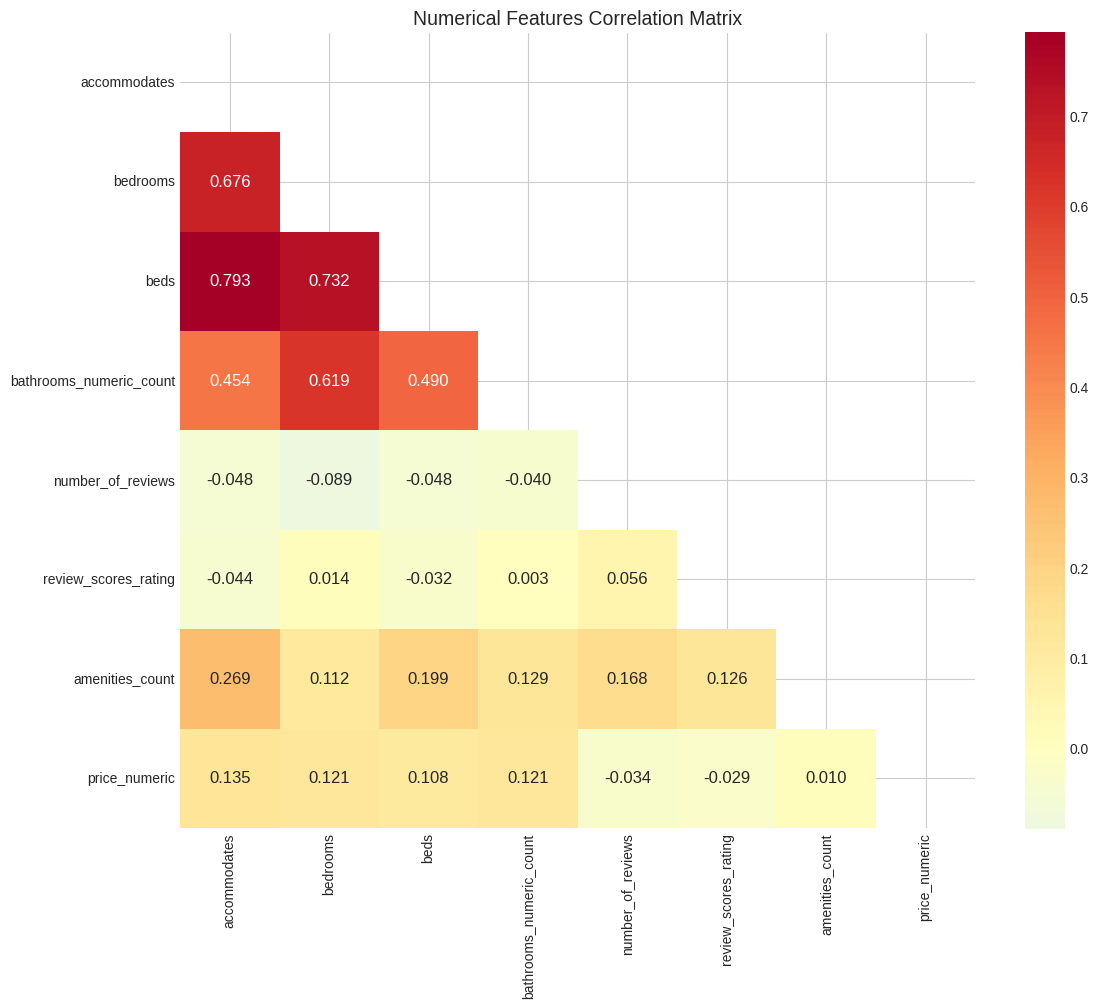

In [19]:
numerical_features = [
    "accommodates",
    "bedrooms",
    "beds",
    "bathrooms_numeric_count",
    "number_of_reviews",
    "review_scores_rating",
    "amenities_count",
    "price_numeric",
]
available_numerical = [
    col for col in numerical_features if col in listings_processed.columns
]

if len(available_numerical) > 1:
    numerical_data = listings_processed[available_numerical].select_dtypes(
        include=[np.number]
    )

    if not numerical_data.empty:
        plt.figure(figsize=(12, 10))
        correlation_matrix = numerical_data.corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(
            correlation_matrix,
            mask=mask,
            annot=True,
            fmt=".3f",
            cmap="RdYlBu_r",
            center=0,
            square=True,
        )
        plt.title("Numerical Features Correlation Matrix")
        plt.tight_layout()
        save_current_plot("numerical_features_correlation_matrix")
        plt.show()

Plot saved: 27_price_by_room_type_and_superhost.png


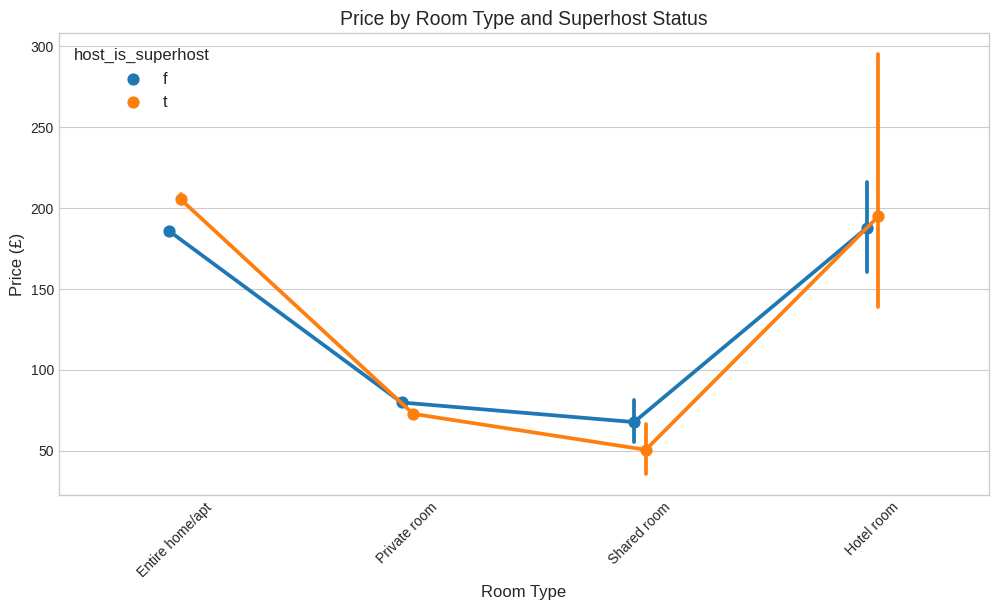

Plot saved: 28_price_by_room_type_and_instant_bookable.png


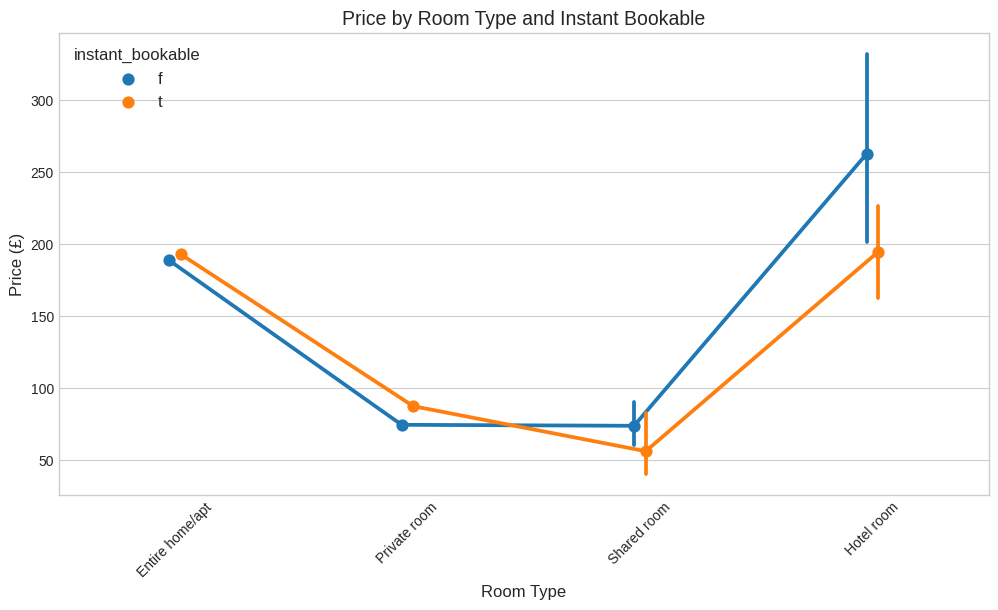

In [20]:
if (
    "room_type" in listings_processed.columns
    and "host_is_superhost" in listings_processed.columns
):
    interaction_data = listings_processed[
        (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
        & (listings_processed["room_type"].notna())
        & (listings_processed["host_is_superhost"].notna())
    ]

    if not interaction_data.empty:
        plt.figure(figsize=(12, 6))
        sns.pointplot(
            data=interaction_data,
            x="room_type",
            y="price_numeric",
            hue="host_is_superhost",
            dodge=True,
        )
        plt.title("Price by Room Type and Superhost Status")
        plt.xlabel("Room Type")
        plt.ylabel("Price (£)")
        plt.xticks(rotation=45)
        save_current_plot("price_by_room_type_and_superhost")
        plt.show()

if (
    "room_type" in listings_processed.columns
    and "instant_bookable" in listings_processed.columns
):
    interaction_data2 = listings_processed[
        (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
        & (listings_processed["room_type"].notna())
        & (listings_processed["instant_bookable"].notna())
    ]

    if not interaction_data2.empty:
        plt.figure(figsize=(12, 6))
        sns.pointplot(
            data=interaction_data2,
            x="room_type",
            y="price_numeric",
            hue="instant_bookable",
            dodge=True,
        )
        plt.title("Price by Room Type and Instant Bookable")
        plt.xlabel("Room Type")
        plt.ylabel("Price (£)")
        plt.xticks(rotation=45)
        save_current_plot("price_by_room_type_and_instant_bookable")
        plt.show()

## VI. Text-Derived Features Validation

Plot saved: 29_price_vs_name_length.png


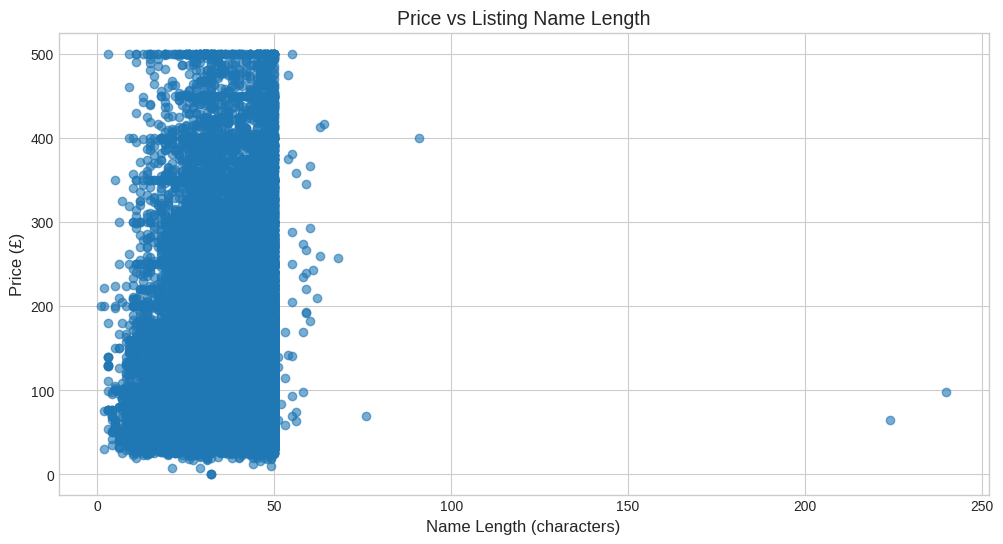

Plot saved: 30_price_vs_description_length.png


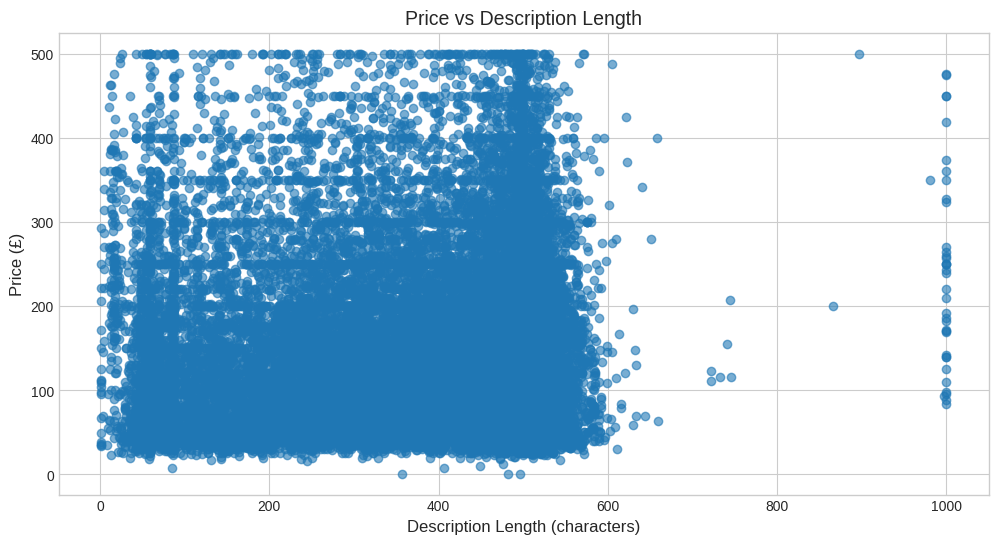

Plot saved: 31_review_scores_vs_description_length.png


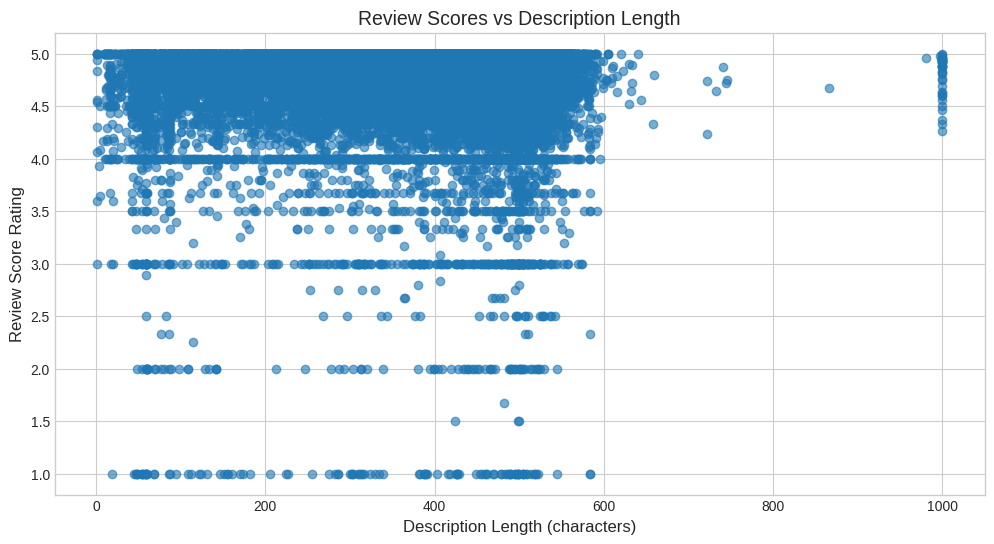

In [21]:
if "name_length" in listings_processed.columns:
    valid_name_data = listings_processed[
        (listings_processed["name_length"].notna())
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
    ]

    if not valid_name_data.empty:
        plt.figure(figsize=(12, 6))
        plt.scatter(
            valid_name_data["name_length"], valid_name_data["price_numeric"], alpha=0.6
        )
        plt.title("Price vs Listing Name Length")
        plt.xlabel("Name Length (characters)")
        plt.ylabel("Price (£)")
        save_current_plot("price_vs_name_length")
        plt.show()

if "description_length" in listings_processed.columns:
    valid_desc_data = listings_processed[
        (listings_processed["description_length"].notna())
        & (listings_processed["price_numeric"] > 0)
        & (
            listings_processed["price_numeric"]
            <= listings_processed["price_numeric"].quantile(0.95)
        )
    ]

    if not valid_desc_data.empty:
        plt.figure(figsize=(12, 6))
        plt.scatter(
            valid_desc_data["description_length"],
            valid_desc_data["price_numeric"],
            alpha=0.6,
        )
        plt.title("Price vs Description Length")
        plt.xlabel("Description Length (characters)")
        plt.ylabel("Price (£)")
        save_current_plot("price_vs_description_length")
        plt.show()

        if "review_scores_rating" in listings_processed.columns:
            valid_desc_review_data = valid_desc_data[
                valid_desc_data["review_scores_rating"].notna()
            ]
            if not valid_desc_review_data.empty:
                plt.figure(figsize=(12, 6))
                plt.scatter(
                    valid_desc_review_data["description_length"],
                    valid_desc_review_data["review_scores_rating"],
                    alpha=0.6,
                )
                plt.title("Review Scores vs Description Length")
                plt.xlabel("Description Length (characters)")
                plt.ylabel("Review Score Rating")
                save_current_plot("review_scores_vs_description_length")
                plt.show()

## Feature Engineering Insights Summary

This visualization suite provides key insights for feature engineering decisions:

### Host Features
- Superhost status and identity verification show clear price premiums
- Host response metrics exhibit ordinal relationships with both price and reviews
- Recommend ordinal encoding for response time and direct use of binary flags

### Core Listing Attributes  
- Bedrooms, beds, and accommodates show strong positive relationships with price
- Bathroom count and type (private/shared) are significant price drivers
- Minimum nights shows non-linear patterns suggesting binning opportunities
- Amenity count correlates with price; specific amenities show differential impacts

### Review Scores
- High correlation between review sub-scores indicates potential redundancy
- Location and value scores show strongest price relationships
- Consider composite scoring or feature selection to reduce dimensionality

### Calendar Patterns
- Clear seasonal and day-of-week pricing patterns
- Strong justification for time-based features in models
- Weekend premiums and seasonal variations support calendar-derived features

### Feature Interactions
- Room type interacts significantly with host characteristics
- Strong correlations between numerical features inform multicollinearity considerations
- Interaction terms between categorical features may improve model performance

### Text Features
- Basic text length features show weak relationships
- More sophisticated NLP approaches may be needed for text-derived insights
- Description length shows some correlation with review scores

In [22]:
# Summary of saved plots
print(f"\n=== PLOT SAVING SUMMARY ===")
print(f"Total plots saved: {plot_counter - 1}")
print(f"Plots directory: {plots_dir}")


# List all saved files
import glob

saved_files = glob.glob(str(plots_dir / "*.png"))
print(f"\nSaved plot files:")
for i, file in enumerate(sorted(saved_files), 1):
    print(f"{i:2d}. {Path(file).name}")


=== PLOT SAVING SUMMARY ===
Total plots saved: 31
Plots directory: ../reports/figures/etap2_professional

Saved plot files:
 1. 01_price_by_superhost_status.png
 2. 02_price_by_host_identity_verified.png
 3. 03_review_scores_by_superhost_status.png
 4. 04_price_by_host_response_time.png
 5. 05_price_vs_host_response_rate.png
 6. 06_review_scores_vs_host_response_rate.png
 7. 07_price_by_bedrooms.png
 8. 08_price_by_beds.png
 9. 09_price_by_accommodates.png
10. 10_price_by_bathroom_count.png
11. 11_price_by_bathroom_type.png
12. 12_minimum_nights_distribution.png
13. 13_price_vs_minimum_nights.png
14. 14_price_vs_amenities_count.png
15. 15_price_by_wifi.png
16. 16_price_by_kitchen.png
17. 17_price_by_air_conditioning.png
18. 18_price_by_pool.png
19. 19_price_by_free_parking.png
20. 20_review_scores_correlation_matrix.png
21. 21_price_vs_location.png
22. 22_price_vs_value.png
23. 23_price_vs_cleanliness.png
24. 24_average_price_by_month.png
25. 25_average_price_by_day_of_week.png
26. 26